# Flower Recognition with ResNet

In [ ]:
#installing required packages
!pip install torch torchvision pandas numpy matplotlib scikit-learn pillow scipy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torch.nn.functional as F

import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

from sklearn.metrics import confusion_matrix, classification_report
import scipy
from PIL import Image
import os
import shutil
import time
from tempfile import TemporaryDirectory
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

Using device: cpu
Using device: cpu


In [ ]:
# Set up data loading and preprocessing
import os
import scipy.io
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# Data directories
data_dir = 'data/flowers-102'
images_dir = os.path.join(data_dir, 'jpg')

# Load mat files for labels and train/val/test splits
labels = scipy.io.loadmat(os.path.join(data_dir, 'imagelabels.mat'))['labels'][0] - 1  # Convert to 0-based indexing
splits = scipy.io.loadmat(os.path.join(data_dir, 'setid.mat'))

# Get indices for train, val, and test sets
train_idx = splits['trnid'][0] - 1  # Convert to 0-based indexing
val_idx = splits['valid'][0] - 1
test_idx = splits['tstid'][0] - 1

class Flowers102Dataset(Dataset):
    def __init__(self, image_dir, indices, labels, transform=None):
        self.image_dir = image_dir
        self.indices = indices
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        img_idx = self.indices[idx]
        img_name = f'image_{img_idx+1:05d}.jpg'
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        label = self.labels[img_idx]
        return image, label
#define transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

#create datasets
train_dataset = Flowers102Dataset(images_dir, train_idx, labels, train_transform)
val_dataset = Flowers102Dataset(images_dir, val_idx, labels, val_test_transform)
test_dataset = Flowers102Dataset(images_dir, test_idx, labels, val_test_transform)

#create dataloaders
batch_size = 32
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4),
    'test': DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
}

dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset),
    'test': len(test_dataset)
}

print(f"Dataset sizes:")
print(f"Training: {dataset_sizes['train']} images")
print(f"Validation: {dataset_sizes['val']} images")
print(f"Test: {dataset_sizes['test']} images")

Dataset sizes:
Training: 1020 images
Validation: 1020 images
Test: 6149 images


Training samples:


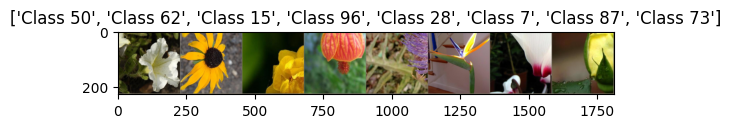

In [ ]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

#visualise some training images
def visualize_samples(dataloader, num_images=8):
    inputs, classes = next(iter(dataloader))
    out = torchvision.utils.make_grid(inputs[:num_images])
    imshow(out, title=[f'Class {x}' for x in classes[:num_images]])

print("Training samples:")
visualize_samples(dataloaders['train'])

In [ ]:
# Base ResNet Model
class FlowerResNet(nn.Module):
    def __init__(self, base_model='resnet18', pretrained=True, num_classes=102):
        super(FlowerResNet, self).__init__()
        
        if base_model == 'resnet18':
            if pretrained:
                self.backbone = models.resnet18(weights='IMAGENET1K_V1')
            else:
                self.backbone = models.resnet18(weights=None)
        elif base_model == 'resnet34':
            if pretrained:
                self.backbone = models.resnet34(weights='IMAGENET1K_V1')
            else:
                self.backbone = models.resnet34(weights=None)
        else:
            raise ValueError("Unsupported base model")
        
        # Replace the final fully connected layer
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_features, num_classes)
        
    def forward(self, x):
        return self.backbone(x)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, model_name='resnet18'):
    since = time.time()
    
    # Create checkpoint directory
    checkpoint_path = './model_checkpoints'
    os.makedirs(checkpoint_path, exist_ok=True)
    best_model_params_path = os.path.join(checkpoint_path, f'best_{model_name}_params.pt')
    
    #save initial model
    torch.save(model.state_dict(), best_model_params_path)
    
    #tracking metrics
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        
        #each epoch has training and validation phases
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            #iterating over data with progress bar
            pbar = tqdm(dataloaders[phase], desc=f'{phase.capitalize()} Epoch {epoch}')
            for inputs, labels in pbar:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                #forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    #backward + optimize only in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                #statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                #update progress bar
                pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Acc': f'{torch.sum(preds == labels.data).item() / inputs.size(0):.4f}'
                })
            
            if phase == 'train' and scheduler is not None:
                scheduler.step()
            
            #calculate epoch metrics
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            #store metrics
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc.cpu())
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc.cpu())
            
            #save best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), best_model_params_path)
                print(f'New best model saved with val_acc: {best_acc:.4f}')

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    #load best model weights
    model.load_state_dict(torch.load(best_model_params_path))
    
    return model, train_losses, train_accs, val_losses, val_accs

In [ ]:
def plot_training_curves(train_losses, val_losses, train_accs, val_accs, model_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(val_losses, label='Val Loss')
    ax1.set_title(f'{model_name} - Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    ax2.plot(train_accs, label='Train Acc')
    ax2.plot(val_accs, label='Val Acc')
    ax2.set_title(f'{model_name} - Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'{model_name}_training_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

def visualize_model_predictions(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(12, 8))

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                
                color = 'green' if preds[j] == labels[j] else 'red'
                ax.set_title(f'Pred: {preds[j].item()} | True: {labels[j].item()}',
                           color=color, fontweight='bold')
                
                # Denormalize and show image
                inp = inputs.cpu().data[j]
                inp = inp.numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                inp = std * inp + mean
                inp = np.clip(inp, 0, 1)
                ax.imshow(inp)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

def evaluate_model(model, criterion):
    was_training = model.training
    model.eval()
    
    test_loss = 0.0
    correct = 0
    all_preds = []
    all_labels = []
    
    print("Evaluating on test set...")
    with torch.no_grad():
        for inputs, labels in tqdm(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            test_loss += criterion(outputs, labels).item() * inputs.size(0)
            correct += torch.sum(preds == labels.data)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    test_loss /= dataset_sizes['test']
    test_acc = correct.double() / dataset_sizes['test']
    
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_acc:.4f}')
    
    model.train(mode=was_training)
    return test_loss, test_acc, all_preds, all_labels

def plot_confusion_matrix(all_labels, all_preds, class_names=None):
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', 
                xticklabels=class_names if class_names else range(102),
                yticklabels=class_names if class_names else range(102))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/UG/rishika004/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 275MB/s]



Model architecture:
backbone.layer4.0.conv1.weight: torch.Size([512, 256, 3, 3])
backbone.layer4.0.bn1.weight: torch.Size([512])
backbone.layer4.0.bn1.bias: torch.Size([512])
backbone.layer4.0.conv2.weight: torch.Size([512, 512, 3, 3])
backbone.layer4.0.bn2.weight: torch.Size([512])
backbone.layer4.0.bn2.bias: torch.Size([512])
backbone.layer4.0.downsample.0.weight: torch.Size([512, 256, 1, 1])
backbone.layer4.0.downsample.1.weight: torch.Size([512])
backbone.layer4.0.downsample.1.bias: torch.Size([512])
backbone.layer4.1.conv1.weight: torch.Size([512, 512, 3, 3])
backbone.layer4.1.bn1.weight: torch.Size([512])
backbone.layer4.1.bn1.bias: torch.Size([512])
backbone.layer4.1.conv2.weight: torch.Size([512, 512, 3, 3])
backbone.layer4.1.bn2.weight: torch.Size([512])
backbone.layer4.1.bn2.bias: torch.Size([512])
backbone.fc.weight: torch.Size([102, 512])
backbone.fc.bias: torch.Size([102])
Epoch 0/49
----------
Epoch 0/49
----------


Train Epoch 0: 100%|██████████| 32/32 [00:24<00:00,  1.33it/s, Loss=4.5855, Acc=0.0357]


train Loss: 4.6938 Acc: 0.0147


Val Epoch 0: 100%|██████████| 32/32 [00:07<00:00,  4.56it/s, Loss=4.2075, Acc=0.1429]



val Loss: 4.3728 Acc: 0.0804
New best model saved with val_acc: 0.0804

Epoch 1/49
----------
New best model saved with val_acc: 0.0804

Epoch 1/49
----------


Train Epoch 1: 100%|██████████| 32/32 [00:14<00:00,  2.21it/s, Loss=3.8780, Acc=0.2857]


train Loss: 4.2212 Acc: 0.1206


Val Epoch 1: 100%|██████████| 32/32 [00:04<00:00,  7.41it/s, Loss=3.4918, Acc=0.4643]



val Loss: 3.8982 Acc: 0.2588
New best model saved with val_acc: 0.2588

Epoch 2/49
----------
New best model saved with val_acc: 0.2588

Epoch 2/49
----------


Train Epoch 2: 100%|██████████| 32/32 [00:11<00:00,  2.68it/s, Loss=3.4896, Acc=0.4286]


train Loss: 3.7541 Acc: 0.3216


Val Epoch 2: 100%|██████████| 32/32 [00:04<00:00,  7.58it/s, Loss=2.8661, Acc=0.6786]



val Loss: 3.3844 Acc: 0.4510
New best model saved with val_acc: 0.4510

Epoch 3/49
----------
New best model saved with val_acc: 0.4510

Epoch 3/49
----------


Train Epoch 3: 100%|██████████| 32/32 [00:11<00:00,  2.81it/s, Loss=2.8084, Acc=0.5714]


train Loss: 3.2675 Acc: 0.4980


Val Epoch 3: 100%|██████████| 32/32 [00:04<00:00,  7.44it/s, Loss=2.1523, Acc=0.8929]



val Loss: 2.8553 Acc: 0.5618
New best model saved with val_acc: 0.5618

Epoch 4/49
----------
New best model saved with val_acc: 0.5618

Epoch 4/49
----------


Train Epoch 4: 100%|██████████| 32/32 [00:12<00:00,  2.66it/s, Loss=2.8464, Acc=0.5714]


train Loss: 2.8044 Acc: 0.6088


Val Epoch 4: 100%|██████████| 32/32 [00:04<00:00,  7.41it/s, Loss=1.6883, Acc=0.9643]



val Loss: 2.4634 Acc: 0.6363
New best model saved with val_acc: 0.6363

Epoch 5/49
----------
New best model saved with val_acc: 0.6363

Epoch 5/49
----------


Train Epoch 5: 100%|██████████| 32/32 [00:11<00:00,  2.77it/s, Loss=2.3858, Acc=0.6786]


train Loss: 2.4319 Acc: 0.6892


Val Epoch 5: 100%|██████████| 32/32 [00:04<00:00,  7.85it/s, Loss=1.2651, Acc=0.9643]



val Loss: 2.0758 Acc: 0.6941
New best model saved with val_acc: 0.6941

Epoch 6/49
----------
New best model saved with val_acc: 0.6941

Epoch 6/49
----------


Train Epoch 6: 100%|██████████| 32/32 [00:11<00:00,  2.81it/s, Loss=1.8713, Acc=0.8571]


train Loss: 2.1545 Acc: 0.7196


Val Epoch 6: 100%|██████████| 32/32 [00:04<00:00,  7.55it/s, Loss=1.1191, Acc=0.9643]



val Loss: 1.7987 Acc: 0.7304
New best model saved with val_acc: 0.7304

Epoch 7/49
----------
New best model saved with val_acc: 0.7304

Epoch 7/49
----------


Train Epoch 7: 100%|██████████| 32/32 [00:10<00:00,  2.94it/s, Loss=2.1714, Acc=0.7143]


train Loss: 1.8906 Acc: 0.7608


Val Epoch 7: 100%|██████████| 32/32 [00:04<00:00,  7.59it/s, Loss=0.9530, Acc=0.9286]



val Loss: 1.5824 Acc: 0.7559
New best model saved with val_acc: 0.7559

Epoch 8/49
----------
New best model saved with val_acc: 0.7559

Epoch 8/49
----------


Train Epoch 8: 100%|██████████| 32/32 [00:11<00:00,  2.82it/s, Loss=1.3070, Acc=0.8929]


train Loss: 1.6476 Acc: 0.8010


Val Epoch 8: 100%|██████████| 32/32 [00:04<00:00,  7.38it/s, Loss=0.8683, Acc=0.9643]



val Loss: 1.4041 Acc: 0.7912
New best model saved with val_acc: 0.7912

Epoch 9/49
----------
New best model saved with val_acc: 0.7912

Epoch 9/49
----------


Train Epoch 9: 100%|██████████| 32/32 [00:12<00:00,  2.63it/s, Loss=1.6843, Acc=0.7500]


train Loss: 1.4937 Acc: 0.8265


Val Epoch 9: 100%|██████████| 32/32 [00:03<00:00,  8.03it/s, Loss=0.6208, Acc=1.0000]



val Loss: 1.2803 Acc: 0.8049
New best model saved with val_acc: 0.8049

Epoch 10/49
----------
New best model saved with val_acc: 0.8049

Epoch 10/49
----------


Train Epoch 10: 100%|██████████| 32/32 [00:11<00:00,  2.76it/s, Loss=1.2411, Acc=0.8929]


train Loss: 1.3188 Acc: 0.8510


Val Epoch 10: 100%|██████████| 32/32 [00:04<00:00,  7.97it/s, Loss=0.6603, Acc=0.9643]



val Loss: 1.1605 Acc: 0.8245
New best model saved with val_acc: 0.8245

Epoch 11/49
----------
New best model saved with val_acc: 0.8245

Epoch 11/49
----------


Train Epoch 11: 100%|██████████| 32/32 [00:11<00:00,  2.69it/s, Loss=1.1104, Acc=0.8214]


train Loss: 1.1799 Acc: 0.8804


Val Epoch 11: 100%|██████████| 32/32 [00:04<00:00,  7.71it/s, Loss=0.5977, Acc=0.9286]



val Loss: 1.0346 Acc: 0.8343
New best model saved with val_acc: 0.8343

Epoch 12/49
----------
New best model saved with val_acc: 0.8343

Epoch 12/49
----------


Train Epoch 12: 100%|██████████| 32/32 [00:11<00:00,  2.78it/s, Loss=1.0787, Acc=0.8571]


train Loss: 1.0743 Acc: 0.8784


Val Epoch 12: 100%|██████████| 32/32 [00:04<00:00,  7.56it/s, Loss=0.6188, Acc=0.9286]



val Loss: 0.9809 Acc: 0.8471
New best model saved with val_acc: 0.8471

Epoch 13/49
----------
New best model saved with val_acc: 0.8471

Epoch 13/49
----------


Train Epoch 13: 100%|██████████| 32/32 [00:10<00:00,  2.97it/s, Loss=1.1673, Acc=0.8571]


train Loss: 0.9906 Acc: 0.8765


Val Epoch 13: 100%|██████████| 32/32 [00:04<00:00,  7.45it/s, Loss=0.5340, Acc=0.9643]



val Loss: 0.9082 Acc: 0.8490
New best model saved with val_acc: 0.8490

Epoch 14/49
----------
New best model saved with val_acc: 0.8490

Epoch 14/49
----------


Train Epoch 14: 100%|██████████| 32/32 [00:12<00:00,  2.55it/s, Loss=0.8626, Acc=0.8571]


train Loss: 0.8667 Acc: 0.8990


Val Epoch 14: 100%|██████████| 32/32 [00:04<00:00,  7.70it/s, Loss=0.4701, Acc=0.9643]



val Loss: 0.8374 Acc: 0.8618
New best model saved with val_acc: 0.8618

Epoch 15/49
----------
New best model saved with val_acc: 0.8618

Epoch 15/49
----------


Train Epoch 15: 100%|██████████| 32/32 [00:11<00:00,  2.75it/s, Loss=0.9109, Acc=0.8929]


train Loss: 0.8323 Acc: 0.9010


Val Epoch 15: 100%|██████████| 32/32 [00:04<00:00,  7.51it/s, Loss=0.4278, Acc=0.9643]


val Loss: 0.8056 Acc: 0.8588

Epoch 16/49
----------


Train Epoch 16: 100%|██████████| 32/32 [00:11<00:00,  2.78it/s, Loss=0.8714, Acc=0.9286]


train Loss: 0.7677 Acc: 0.9235


Val Epoch 16: 100%|██████████| 32/32 [00:04<00:00,  7.46it/s, Loss=0.3741, Acc=0.9643]



val Loss: 0.7662 Acc: 0.8706
New best model saved with val_acc: 0.8706

Epoch 17/49
----------
New best model saved with val_acc: 0.8706

Epoch 17/49
----------


Train Epoch 17: 100%|██████████| 32/32 [00:11<00:00,  2.68it/s, Loss=0.9215, Acc=0.8571]


train Loss: 0.7063 Acc: 0.9275


Val Epoch 17: 100%|██████████| 32/32 [00:04<00:00,  7.93it/s, Loss=0.4086, Acc=0.9643]


val Loss: 0.7404 Acc: 0.8706

Epoch 18/49
----------


Train Epoch 18: 100%|██████████| 32/32 [00:10<00:00,  2.97it/s, Loss=0.5809, Acc=0.9643]


train Loss: 0.6473 Acc: 0.9245


Val Epoch 18: 100%|██████████| 32/32 [00:04<00:00,  7.72it/s, Loss=0.3865, Acc=0.9643]



val Loss: 0.6787 Acc: 0.8794
New best model saved with val_acc: 0.8794

Epoch 19/49
----------
New best model saved with val_acc: 0.8794

Epoch 19/49
----------


Train Epoch 19: 100%|██████████| 32/32 [00:10<00:00,  2.94it/s, Loss=0.6894, Acc=0.8929]


train Loss: 0.6139 Acc: 0.9343


Val Epoch 19: 100%|██████████| 32/32 [00:04<00:00,  7.79it/s, Loss=0.3731, Acc=0.9643]



val Loss: 0.6663 Acc: 0.8833
New best model saved with val_acc: 0.8833

Epoch 20/49
----------
New best model saved with val_acc: 0.8833

Epoch 20/49
----------


Train Epoch 20: 100%|██████████| 32/32 [00:11<00:00,  2.84it/s, Loss=0.6985, Acc=0.9286]


train Loss: 0.5967 Acc: 0.9333


Val Epoch 20: 100%|██████████| 32/32 [00:04<00:00,  7.71it/s, Loss=0.4130, Acc=0.9643]



val Loss: 0.6256 Acc: 0.8941
New best model saved with val_acc: 0.8941

Epoch 21/49
----------
New best model saved with val_acc: 0.8941

Epoch 21/49
----------


Train Epoch 21: 100%|██████████| 32/32 [00:12<00:00,  2.63it/s, Loss=0.8496, Acc=0.8929]


train Loss: 0.5684 Acc: 0.9363


Val Epoch 21: 100%|██████████| 32/32 [00:04<00:00,  7.26it/s, Loss=0.3658, Acc=0.9643]



val Loss: 0.6056 Acc: 0.9020
New best model saved with val_acc: 0.9020

Epoch 22/49
----------
New best model saved with val_acc: 0.9020

Epoch 22/49
----------


Train Epoch 22: 100%|██████████| 32/32 [00:10<00:00,  2.96it/s, Loss=0.8169, Acc=0.8929]


train Loss: 0.5465 Acc: 0.9333


Val Epoch 22: 100%|██████████| 32/32 [00:04<00:00,  7.41it/s, Loss=0.2421, Acc=0.9643]


val Loss: 0.5962 Acc: 0.8931

Epoch 23/49
----------


Train Epoch 23: 100%|██████████| 32/32 [00:11<00:00,  2.75it/s, Loss=0.6412, Acc=0.9286]


train Loss: 0.5007 Acc: 0.9333


Val Epoch 23: 100%|██████████| 32/32 [00:05<00:00,  6.31it/s, Loss=0.2484, Acc=0.9643]


val Loss: 0.5748 Acc: 0.8941

Epoch 24/49
----------


Train Epoch 24: 100%|██████████| 32/32 [00:11<00:00,  2.80it/s, Loss=0.5082, Acc=0.9286]


train Loss: 0.4760 Acc: 0.9392


Val Epoch 24: 100%|██████████| 32/32 [00:04<00:00,  7.51it/s, Loss=0.2328, Acc=0.9643]


val Loss: 0.5561 Acc: 0.8882

Epoch 25/49
----------


Train Epoch 25: 100%|██████████| 32/32 [00:11<00:00,  2.78it/s, Loss=0.4205, Acc=0.9286]


train Loss: 0.4367 Acc: 0.9500


Val Epoch 25: 100%|██████████| 32/32 [00:04<00:00,  7.55it/s, Loss=0.2750, Acc=0.9643]


val Loss: 0.5413 Acc: 0.9000

Epoch 26/49
----------


Train Epoch 26: 100%|██████████| 32/32 [00:11<00:00,  2.86it/s, Loss=0.7200, Acc=0.8929]


train Loss: 0.4248 Acc: 0.9402


Val Epoch 26: 100%|██████████| 32/32 [00:04<00:00,  7.80it/s, Loss=0.2236, Acc=0.9643]



val Loss: 0.5286 Acc: 0.9118
New best model saved with val_acc: 0.9118

Epoch 27/49
----------
New best model saved with val_acc: 0.9118

Epoch 27/49
----------


Train Epoch 27: 100%|██████████| 32/32 [00:11<00:00,  2.78it/s, Loss=0.4794, Acc=0.9286]


train Loss: 0.4364 Acc: 0.9480


Val Epoch 27: 100%|██████████| 32/32 [00:04<00:00,  7.56it/s, Loss=0.2698, Acc=0.9643]


val Loss: 0.5077 Acc: 0.9118

Epoch 28/49
----------


Train Epoch 28: 100%|██████████| 32/32 [00:11<00:00,  2.77it/s, Loss=0.3773, Acc=0.9286]


train Loss: 0.3801 Acc: 0.9559


Val Epoch 28: 100%|██████████| 32/32 [00:04<00:00,  7.76it/s, Loss=0.2306, Acc=0.9643]


val Loss: 0.5130 Acc: 0.9069

Epoch 29/49
----------


Train Epoch 29: 100%|██████████| 32/32 [00:11<00:00,  2.75it/s, Loss=0.4142, Acc=0.9286]


train Loss: 0.3979 Acc: 0.9461


Val Epoch 29: 100%|██████████| 32/32 [00:04<00:00,  7.81it/s, Loss=0.2236, Acc=0.9643]


val Loss: 0.5001 Acc: 0.9069

Epoch 30/49
----------


Train Epoch 30: 100%|██████████| 32/32 [00:11<00:00,  2.68it/s, Loss=0.2220, Acc=1.0000]


train Loss: 0.3322 Acc: 0.9618


Val Epoch 30: 100%|██████████| 32/32 [00:04<00:00,  7.41it/s, Loss=0.2118, Acc=0.9643]


val Loss: 0.4953 Acc: 0.9039

Epoch 31/49
----------


Train Epoch 31: 100%|██████████| 32/32 [00:11<00:00,  2.70it/s, Loss=0.2806, Acc=1.0000]


train Loss: 0.3269 Acc: 0.9647


Val Epoch 31: 100%|██████████| 32/32 [00:04<00:00,  7.58it/s, Loss=0.2100, Acc=0.9643]


val Loss: 0.4947 Acc: 0.9049

Epoch 32/49
----------


Train Epoch 32: 100%|██████████| 32/32 [00:11<00:00,  2.75it/s, Loss=0.2677, Acc=1.0000]


train Loss: 0.3251 Acc: 0.9657


Val Epoch 32: 100%|██████████| 32/32 [00:04<00:00,  7.86it/s, Loss=0.2198, Acc=0.9643]


val Loss: 0.4967 Acc: 0.9069

Epoch 33/49
----------


Train Epoch 33: 100%|██████████| 32/32 [00:11<00:00,  2.72it/s, Loss=0.4873, Acc=0.8214]


train Loss: 0.3640 Acc: 0.9588


Val Epoch 33: 100%|██████████| 32/32 [00:04<00:00,  7.70it/s, Loss=0.2345, Acc=0.9643]


val Loss: 0.4983 Acc: 0.9029

Epoch 34/49
----------


Train Epoch 34: 100%|██████████| 32/32 [00:12<00:00,  2.62it/s, Loss=0.1895, Acc=1.0000]


train Loss: 0.3153 Acc: 0.9637


Val Epoch 34: 100%|██████████| 32/32 [00:04<00:00,  7.42it/s, Loss=0.1992, Acc=0.9643]


val Loss: 0.4889 Acc: 0.9078

Epoch 35/49
----------


Train Epoch 35: 100%|██████████| 32/32 [00:11<00:00,  2.80it/s, Loss=0.2701, Acc=0.9643]


train Loss: 0.3264 Acc: 0.9696


Val Epoch 35: 100%|██████████| 32/32 [00:04<00:00,  7.71it/s, Loss=0.2056, Acc=0.9643]


val Loss: 0.4831 Acc: 0.9049

Epoch 36/49
----------


Train Epoch 36: 100%|██████████| 32/32 [00:11<00:00,  2.74it/s, Loss=0.3267, Acc=0.8929]


train Loss: 0.3090 Acc: 0.9637


Val Epoch 36: 100%|██████████| 32/32 [00:04<00:00,  7.52it/s, Loss=0.2143, Acc=0.9643]



val Loss: 0.4868 Acc: 0.9137
New best model saved with val_acc: 0.9137

Epoch 37/49
----------
New best model saved with val_acc: 0.9137

Epoch 37/49
----------


Train Epoch 37: 100%|██████████| 32/32 [00:14<00:00,  2.19it/s, Loss=0.2683, Acc=0.9643]


train Loss: 0.3301 Acc: 0.9627


Val Epoch 37: 100%|██████████| 32/32 [00:04<00:00,  7.58it/s, Loss=0.1938, Acc=0.9643]


val Loss: 0.4905 Acc: 0.9118

Epoch 38/49
----------


Train Epoch 38: 100%|██████████| 32/32 [00:11<00:00,  2.68it/s, Loss=0.3496, Acc=0.9643]


train Loss: 0.3400 Acc: 0.9559


Val Epoch 38: 100%|██████████| 32/32 [00:04<00:00,  7.38it/s, Loss=0.2061, Acc=0.9643]


val Loss: 0.4853 Acc: 0.9098

Epoch 39/49
----------


Train Epoch 39: 100%|██████████| 32/32 [00:11<00:00,  2.70it/s, Loss=0.2917, Acc=1.0000]


train Loss: 0.3258 Acc: 0.9647


Val Epoch 39: 100%|██████████| 32/32 [00:04<00:00,  7.33it/s, Loss=0.2148, Acc=0.9643]


val Loss: 0.4822 Acc: 0.9118

Epoch 40/49
----------


Train Epoch 40: 100%|██████████| 32/32 [00:12<00:00,  2.65it/s, Loss=0.2996, Acc=0.9286]


train Loss: 0.3195 Acc: 0.9608


Val Epoch 40: 100%|██████████| 32/32 [00:04<00:00,  7.20it/s, Loss=0.2393, Acc=0.9643]


val Loss: 0.4792 Acc: 0.9108

Epoch 41/49
----------


Train Epoch 41: 100%|██████████| 32/32 [00:11<00:00,  2.69it/s, Loss=0.2670, Acc=0.9286]


train Loss: 0.3284 Acc: 0.9549


Val Epoch 41: 100%|██████████| 32/32 [00:04<00:00,  7.75it/s, Loss=0.2170, Acc=0.9643]



val Loss: 0.4909 Acc: 0.9167
New best model saved with val_acc: 0.9167

Epoch 42/49
----------
New best model saved with val_acc: 0.9167

Epoch 42/49
----------


Train Epoch 42: 100%|██████████| 32/32 [00:17<00:00,  1.88it/s, Loss=0.6636, Acc=0.8929]


train Loss: 0.3364 Acc: 0.9627


Val Epoch 42: 100%|██████████| 32/32 [00:04<00:00,  7.36it/s, Loss=0.2282, Acc=0.9643]


val Loss: 0.4807 Acc: 0.9127

Epoch 43/49
----------


Train Epoch 43: 100%|██████████| 32/32 [00:11<00:00,  2.71it/s, Loss=0.2600, Acc=1.0000]


train Loss: 0.3194 Acc: 0.9667


Val Epoch 43: 100%|██████████| 32/32 [00:05<00:00,  5.52it/s, Loss=0.2272, Acc=0.9643]


val Loss: 0.4823 Acc: 0.9147

Epoch 44/49
----------


Train Epoch 44: 100%|██████████| 32/32 [00:12<00:00,  2.62it/s, Loss=0.4201, Acc=0.9643]


train Loss: 0.3309 Acc: 0.9676


Val Epoch 44: 100%|██████████| 32/32 [00:04<00:00,  7.45it/s, Loss=0.2285, Acc=0.9643]


val Loss: 0.4861 Acc: 0.9127

Epoch 45/49
----------


Train Epoch 45: 100%|██████████| 32/32 [00:11<00:00,  2.74it/s, Loss=0.3421, Acc=1.0000]


train Loss: 0.3269 Acc: 0.9598


Val Epoch 45: 100%|██████████| 32/32 [00:04<00:00,  7.66it/s, Loss=0.2302, Acc=0.9643]


val Loss: 0.4709 Acc: 0.9147

Epoch 46/49
----------


Train Epoch 46: 100%|██████████| 32/32 [00:11<00:00,  2.77it/s, Loss=0.3461, Acc=0.9643]


train Loss: 0.3388 Acc: 0.9588


Val Epoch 46: 100%|██████████| 32/32 [00:04<00:00,  7.37it/s, Loss=0.2267, Acc=0.9643]


val Loss: 0.4763 Acc: 0.9088

Epoch 47/49
----------


Train Epoch 47: 100%|██████████| 32/32 [00:11<00:00,  2.77it/s, Loss=0.3053, Acc=0.9643]


train Loss: 0.3355 Acc: 0.9618


Val Epoch 47: 100%|██████████| 32/32 [00:04<00:00,  7.63it/s, Loss=0.1971, Acc=0.9643]


val Loss: 0.4680 Acc: 0.9108

Epoch 48/49
----------


Train Epoch 48: 100%|██████████| 32/32 [00:11<00:00,  2.70it/s, Loss=0.4291, Acc=0.9643]


train Loss: 0.3292 Acc: 0.9578


Val Epoch 48: 100%|██████████| 32/32 [00:04<00:00,  7.48it/s, Loss=0.2211, Acc=0.9643]


val Loss: 0.4813 Acc: 0.9118

Epoch 49/49
----------


Train Epoch 49: 100%|██████████| 32/32 [00:11<00:00,  2.75it/s, Loss=0.5421, Acc=0.8929]


train Loss: 0.3780 Acc: 0.9559


Val Epoch 49: 100%|██████████| 32/32 [00:04<00:00,  7.73it/s, Loss=0.2081, Acc=0.9643]



val Loss: 0.4751 Acc: 0.9118

Training complete in 13m 52s
Best val Acc: 0.916667


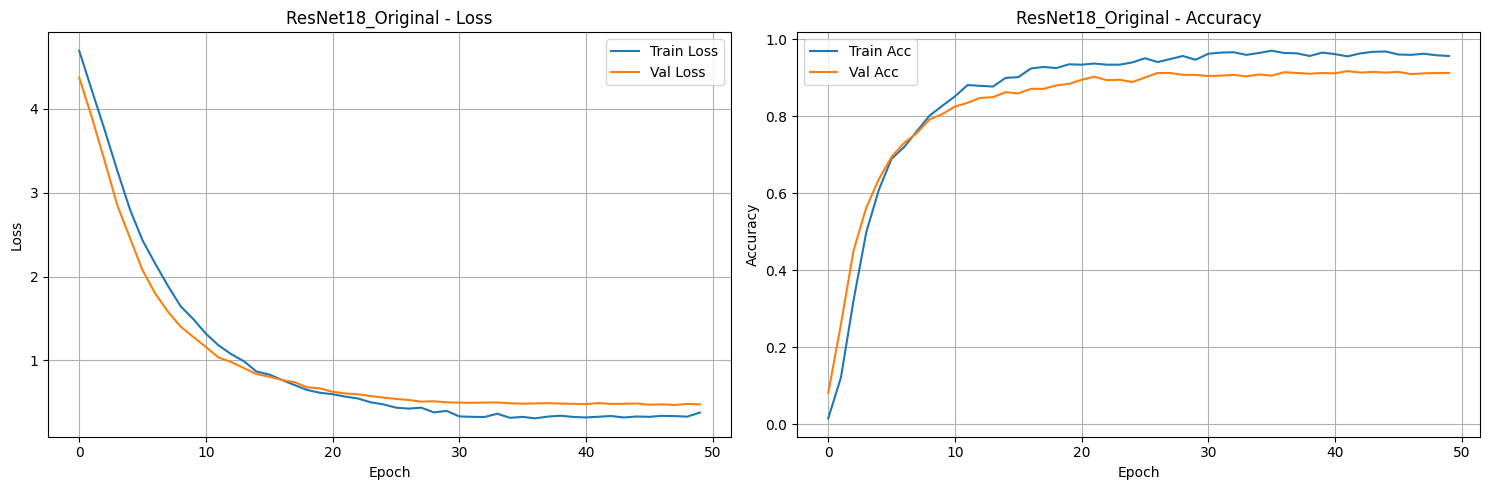

Evaluating on test set...


100%|██████████| 193/193 [00:37<00:00,  5.21it/s]

Test Loss: 0.5874
Test Accuracy: 0.8803
ResNet18 Original - Test Accuracy: 0.8803


In [ ]:

#create model
model_resnet18 = FlowerResNet(base_model='resnet18', pretrained=True, num_classes=102)
model_resnet18 = model_resnet18.to(device)

#display model architecture
print("Model architecture:")
for name, param in model_resnet18.named_parameters():
    if "fc" in name or "layer4" in name:
        print(f"{name}: {param.shape}")

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_resnet18.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Train model
num_epochs = 50
model_resnet18, train_losses, train_accs, val_losses, val_accs = train_model(
    model_resnet18, criterion, optimizer, scheduler, num_epochs, 'resnet18_original'
)

# Plot results
plot_training_curves(train_losses, val_losses, train_accs, val_accs, 'ResNet18_Original')

# Evaluate on test set
test_loss, test_acc, all_preds, all_labels = evaluate_model(model_resnet18, criterion)

# Save training logs
with open('resnet18_original.txt', 'w') as f:
    f.write("Epoch,Train_Loss,Val_Loss,Train_Acc,Val_Acc\n")
    for epoch in range(num_epochs):
        f.write(f"{epoch+1},{train_losses[epoch]:.4f},{val_losses[epoch]:.4f},{train_accs[epoch]:.4f},{val_accs[epoch]:.4f}\n")

print(f"ResNet18 Original - Test Accuracy: {test_acc:.4f}")